# [NY Citi Bike](https://citibikenyc.com/) Data Analysis: Time Series Analysis and Forecasting
Script by Ryan Lee

## Table of Contents

### 1. [Import libraries](#Import_libraries)

### 2. [Import data](#Import_data)

### 3. [Data preparation](#Data_preparation)

### 4. [Time-series analysis](#Time-series_analysis)

- [Decomposition](#decomposition)
 - [Conclusion](#conclusion)
- [Testing for stationarity](#stationarity)
- [Autocorrelation](#autocorrelation)

### 5. [Time-series forecasting](#Time-series_forecasting)

- [Partial autocorrelation](#partial_autocorrelation)
- [Splitting the data](#splitting_data)
- [Running and fitting the model](#modeling)

<a id='Import_libraries'></a>
# 1. Import libraries

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Using .api imports the public access version of statsmodels, which is a library that handles statistical models
import statsmodels.api as sm

import os
import warnings # This is a library that handles warnings.
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # import the autocorrelation and partial correlation plots
from statsmodels.tsa.api import ARIMA

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

<a id='Import_data'></a>
# 2. Import data

In [2]:
# Create a string of the path for the main project folder

path = r'C:\Users\Ryan\Documents\08-31-2023 Citi Bike Analysis'

In [3]:
# Import the “201903-citibike-tripdata-cleaned.pkl” data set using the os library

df_citibike = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', '201903-citibike-tripdata-cleaned.pkl'))

In [4]:
# Check the output

df_citibike.head()

,user_type,gender,age,age_group,trip_duration,start_day_name,start_day,start_hour,start_station,start_latitude,start_longitude,end_station,end_latitude,end_longitude,borough
0,Subscriber,Male,30,26-35,24.379999,Friday,1,0,Fulton St & Broadway,40.711067,-74.009445,Greenwich St & W Houston St,40.728848,-74.008591,Manhattan
1,Subscriber,Male,39,36-45,4.750000,Friday,1,0,E 4 St & 2 Ave,40.726280,-73.989777,E 2 St & Avenue C,40.720875,-73.980858,Manhattan
2,Subscriber,Male,32,26-35,11.430000,Friday,1,0,E 33 St & 5 Ave,40.747658,-73.984909,6 Ave & Spring St,40.725254,-74.004120,Manhattan
3,Subscriber,Female,32,26-35,7.370000,Friday,1,0,6 Ave & Spring St,40.725254,-74.004120,Bayard St & Baxter St,40.716022,-73.999741,Manhattan
4,Subscriber,Male,28,26-35,48.549999,Friday,1,0,W 31 St & 7 Ave,40.749157,-73.991600,W 16 St & The High Line,40.743351,-74.006821,Manhattan


In [5]:
# Check the dimensions

df_citibike.shape

(1255492, 15)

<a id='Data_preparation'></a>
# 3. Data preparation

In [6]:
# Obtain the number of bikes rented for each day

bikes_rented = df_citibike.groupby(df_citibike['start_day']).size()
bikes_rented

start_day
1     29269
2     17157
3     21859
4     27291
5     35931
6     32380
7     34918
8     39031
9     35848
10    18117
11    50028
12    45569
13    48163
14    54990
15    54286
16    38299
17    33816
18    44528
19    50575
20    52880
21    20668
22    34139
23    34565
24    44733
25    51049
26    53144
27    52187
28    55855
29    56185
30    57716
31    30316
dtype: int64

In [7]:
# Create pandas dataframe of 'day' and 'bikes rented'

df = pd.DataFrame({'date': bikes_rented.index, 'bikes_rented': bikes_rented.values})

In [8]:
# Change the start day values to a date

for i in np.arange(1,32):
    df.replace(i, f'2019-03-{i}', inplace=True)

In [9]:
# Check the output

df

,date,bikes_rented
0,2019-03-1,29269
1,2019-03-2,17157
2,2019-03-3,21859
3,2019-03-4,27291
4,2019-03-5,35931
5,2019-03-6,32380
6,2019-03-7,34918
7,2019-03-8,39031
8,2019-03-9,35848
9,2019-03-10,18117


My data has 1,255,492 records, with the 'start_day' values ranging from 1 to 31. I had to group the data by start day so that I could get a count of how many bikes were rented on each of the days for March 2019.

In [10]:
# Convert 'date' column to pandas datetime

df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

In [11]:
# Set the 'day' column as the index

df = df.set_index('date')
df

,bikes_rented
date,
2019-03-01,29269
2019-03-02,17157
2019-03-03,21859
2019-03-04,27291
2019-03-05,35931
2019-03-06,32380
2019-03-07,34918
2019-03-08,39031
2019-03-09,35848


<a id='Time-series_analysis'></a>
# 4. Time-series analysis

Text(0.5, 1.0, 'Bikes Rented for Each Day in March 2019')

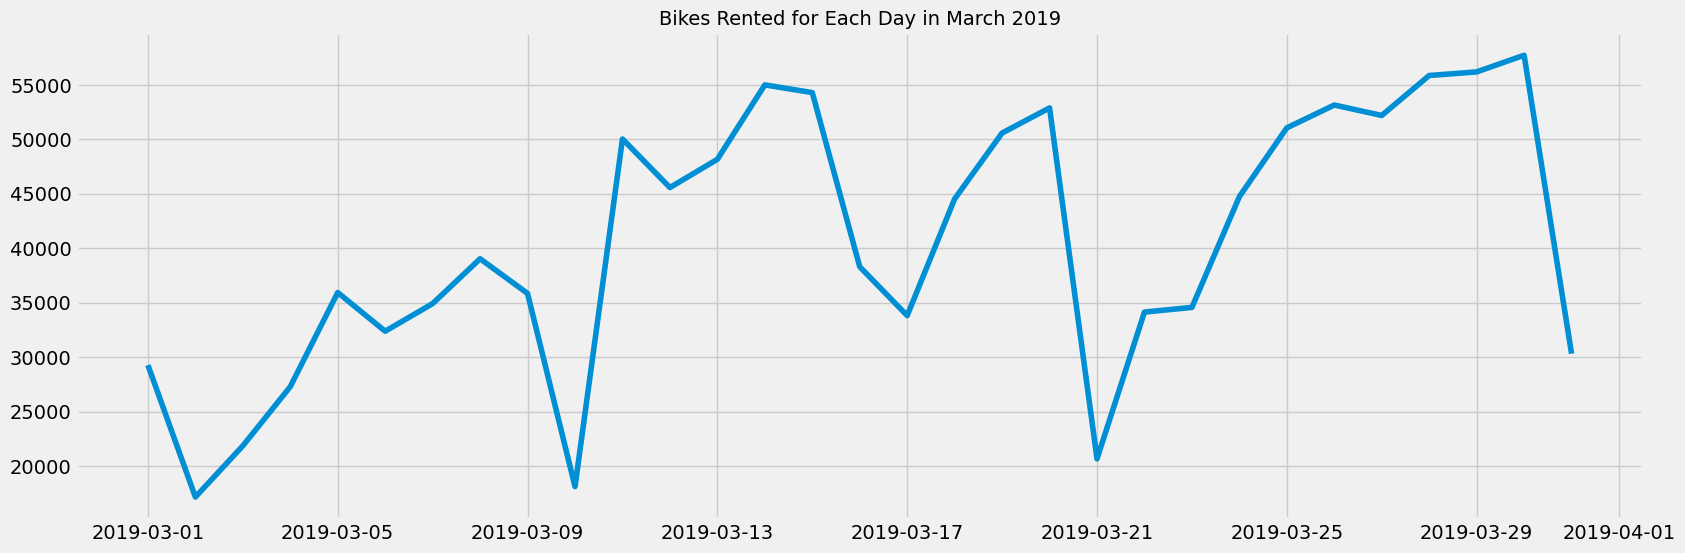

In [12]:
# Plot the data

plt.figure(figsize=(18,6), dpi=100)
plt.plot(df)
plt.title('Bikes Rented for Each Day in March 2019', fontsize=14)

<a id='decomposition'></a>
## Decomposition

In [13]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df, model='additive')

In [14]:
# Define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 12

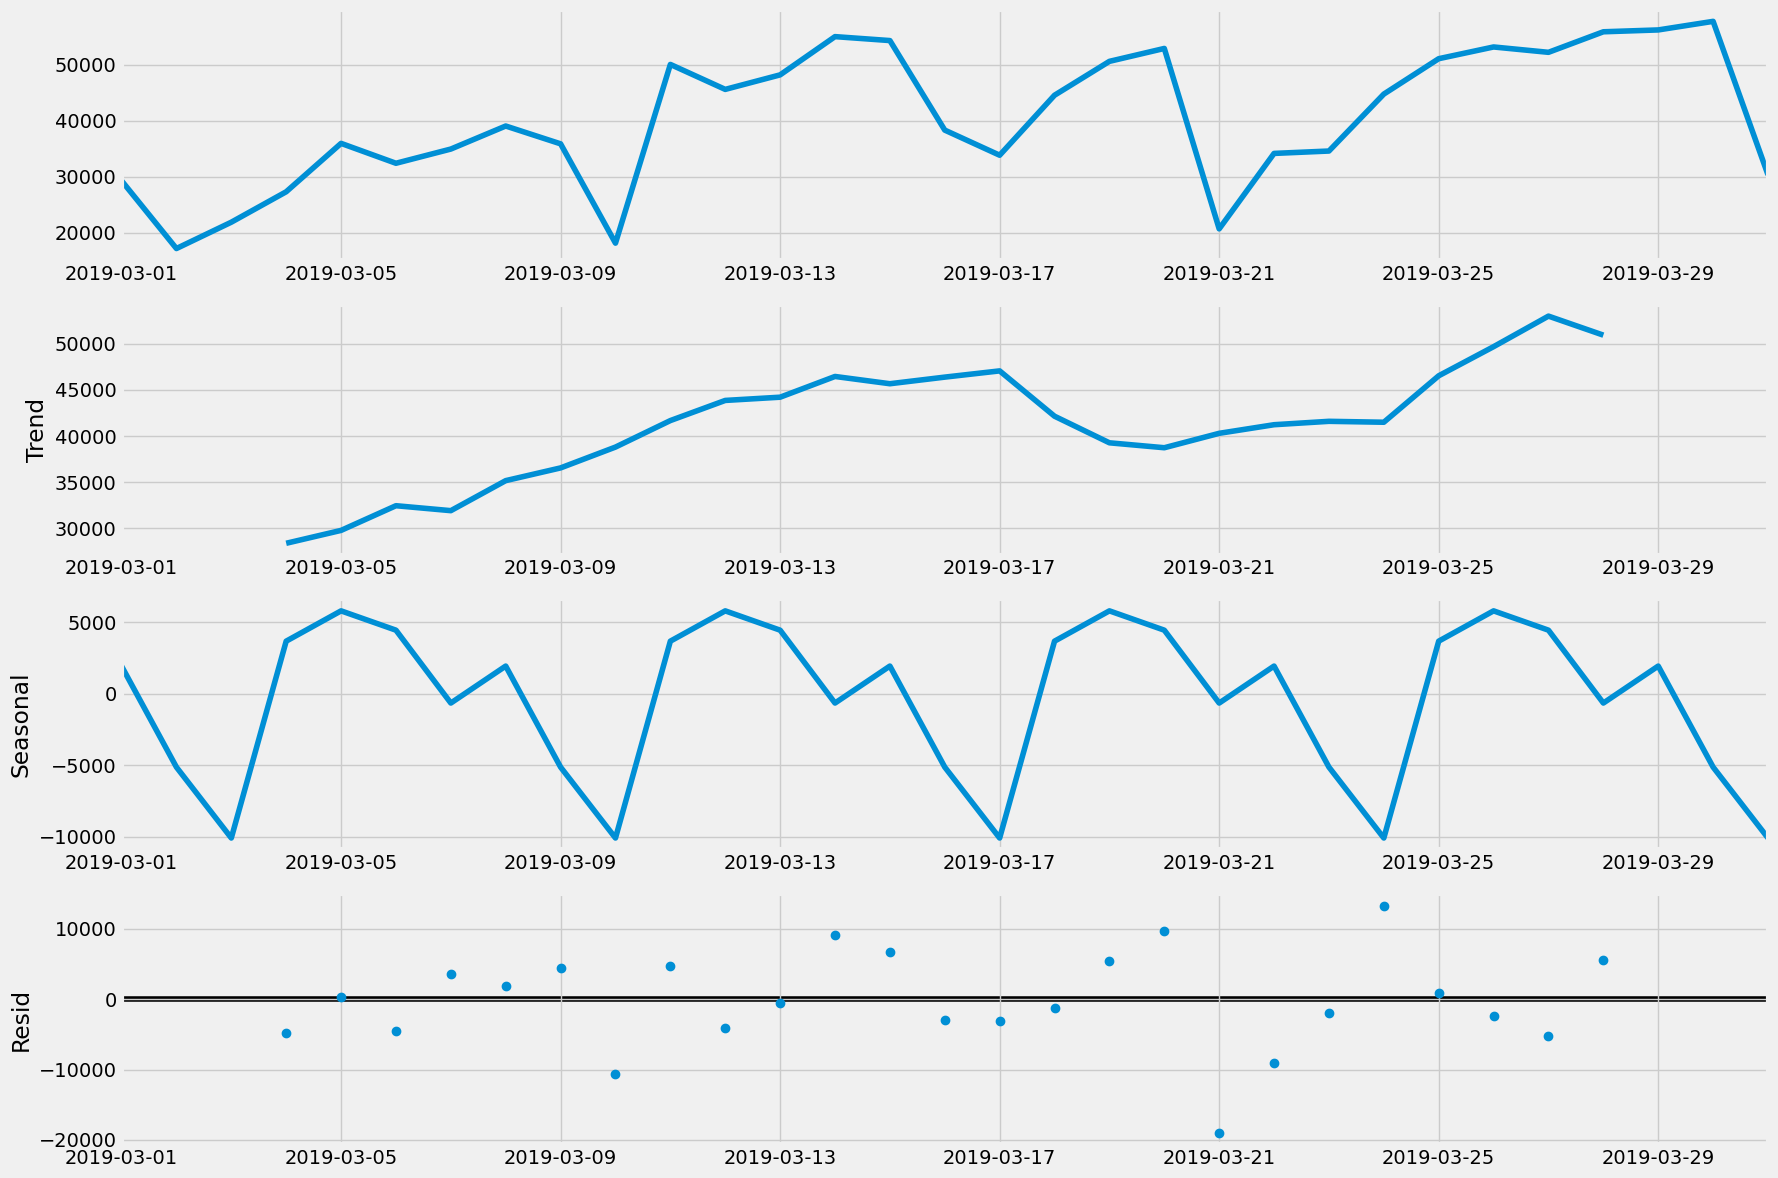

In [15]:
# Plot the separate components

decomposition.plot()
plt.show()

<a id='conclusion'></a>
### Conclusion
- The level and trend are different, indicating there is noise in the original data.
- The overall trend appears to be increasing. There is a slight decrease in the trend from March 17 to March 20.
- There appears to be seasonality in the data.
- There is a good amount of unexplained noise in the data.

<a id='stationarity'></a>
## Testing for stationarity

In [16]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

In [17]:
# Apply the test using the function on the time series

dickey_fuller(df['bikes_rented'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.026288
p-value                         0.032511
Number of Lags Used             0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


- Null hypothesis: There is a unit root (i.e. The data is non-stationary)
- Alternative hypothesis: There is no unit root (i.e. The data is stationary)

Our test statistic is smaller than the critical value at the 5% and 10% level. Thus, we can reject the null hypothesis at the 5% level and conclude there is no unit root; that is, the data is stationary.

**This also means we won't have to perform differencing.**

<a id='autocorrelation'></a>
## Autocorrelation

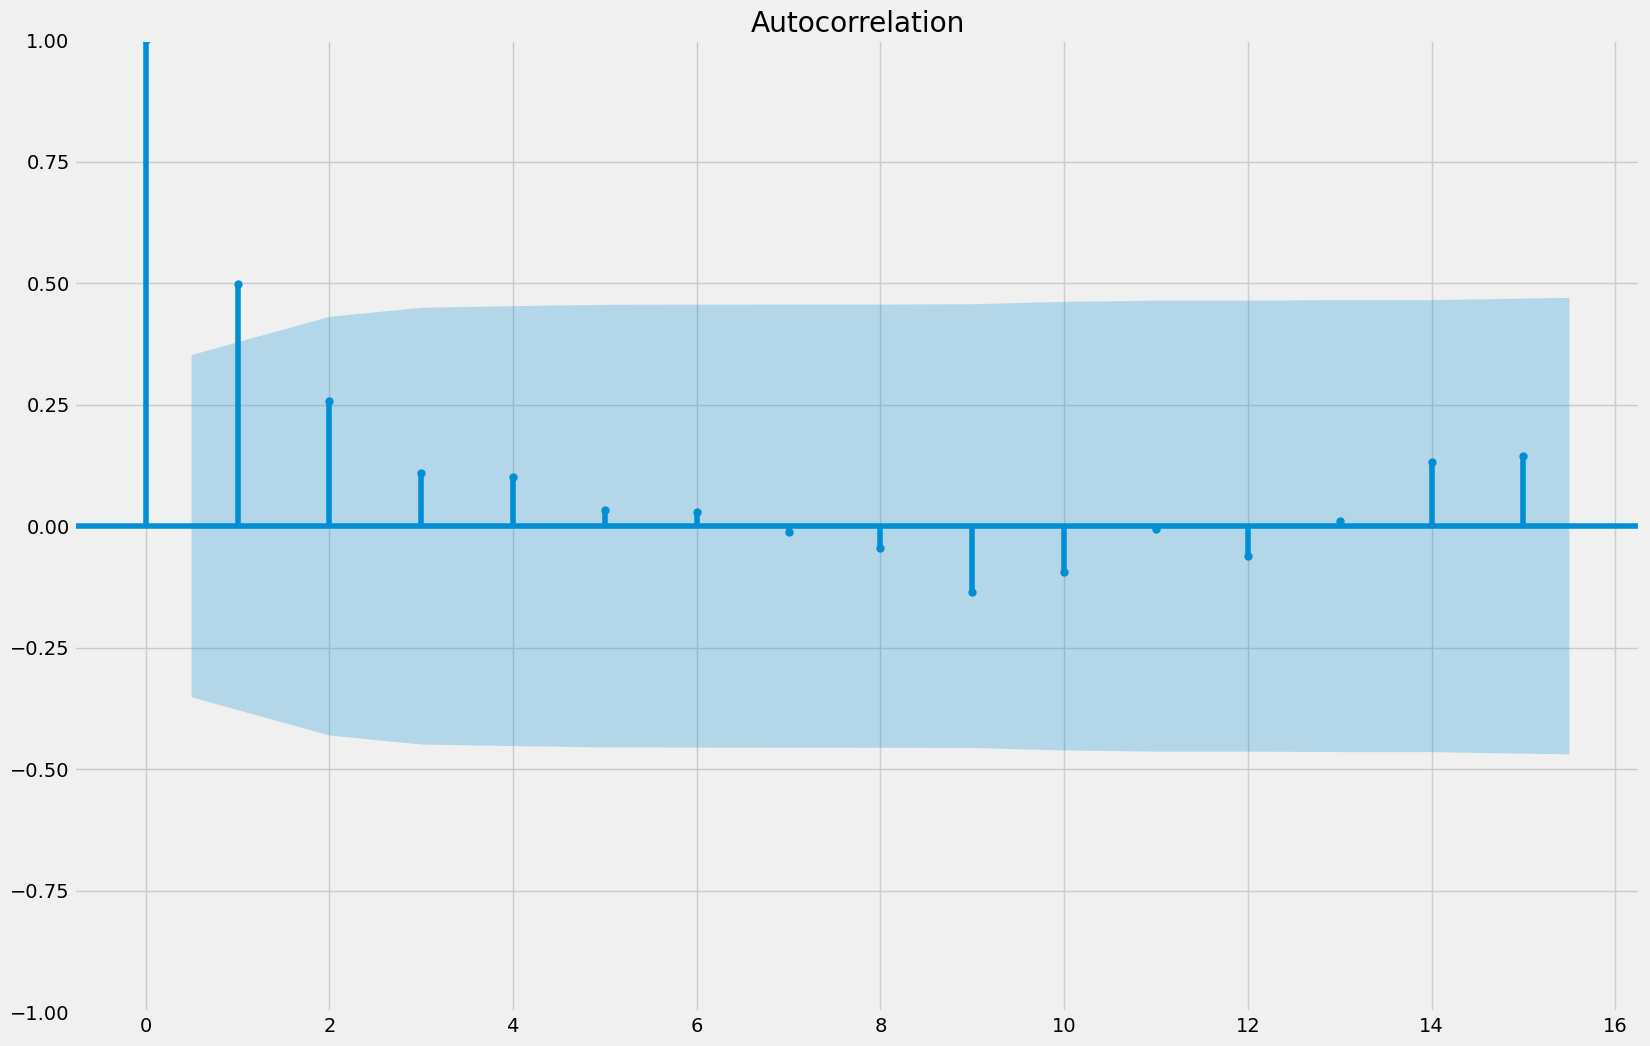

<Figure size 1800x1200 with 0 Axes>

In [18]:
# Check out a plot of autocorrelations

plot_acf(df)
plt.figure(dpi=100)
plt.show()

<a id='Time-series_forecasting'></a>
# 5. Time-series forecasting

<a id='partial_autocorrelation'></a>
## Partial autocorrelation

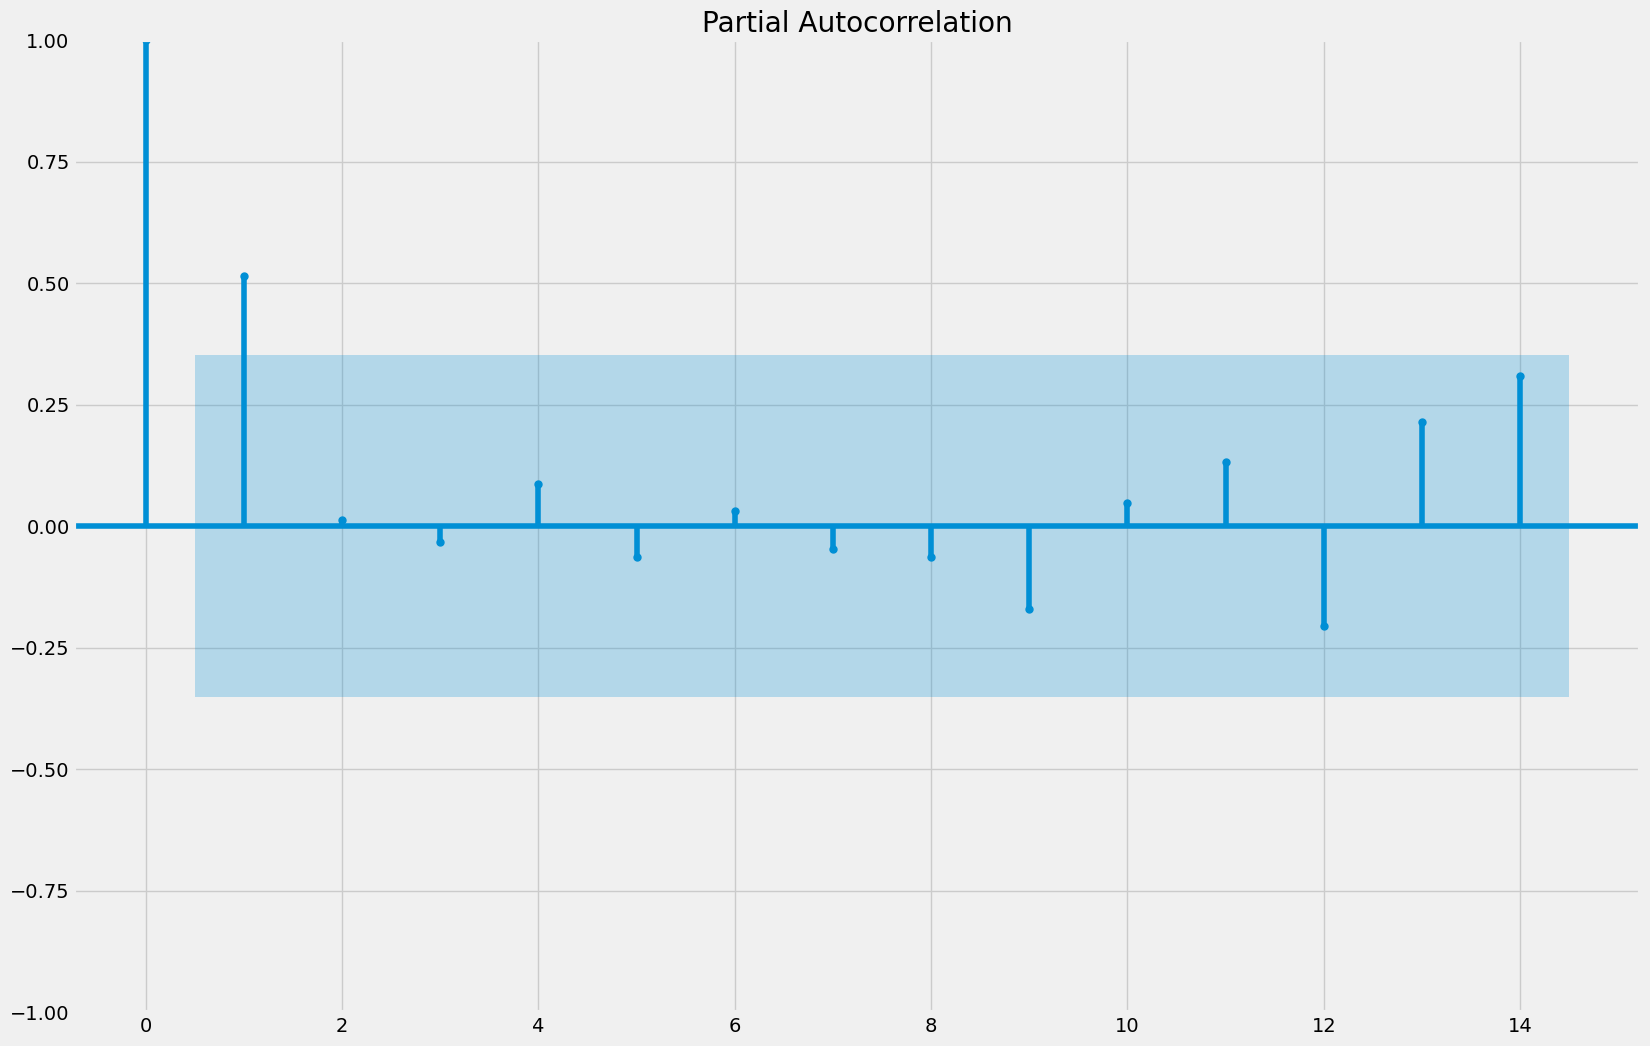

<Figure size 5400x3600 with 0 Axes>

In [19]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(df, lags=14)
plt.figure(dpi=300)
plt.show()

Based on the pacf, we have 2 significant partial autocorrelations, so let's start with p = 1. Since no differencing was done, d = 0. Based on the acf, we have 2 significant autocorrelations, so let's start with q = 1.

<a id='splitting_data'></a>
## Splitting the data

In [20]:
# Split the data

train = df['bikes_rented'][:23]
test = df['bikes_rented'][22:]

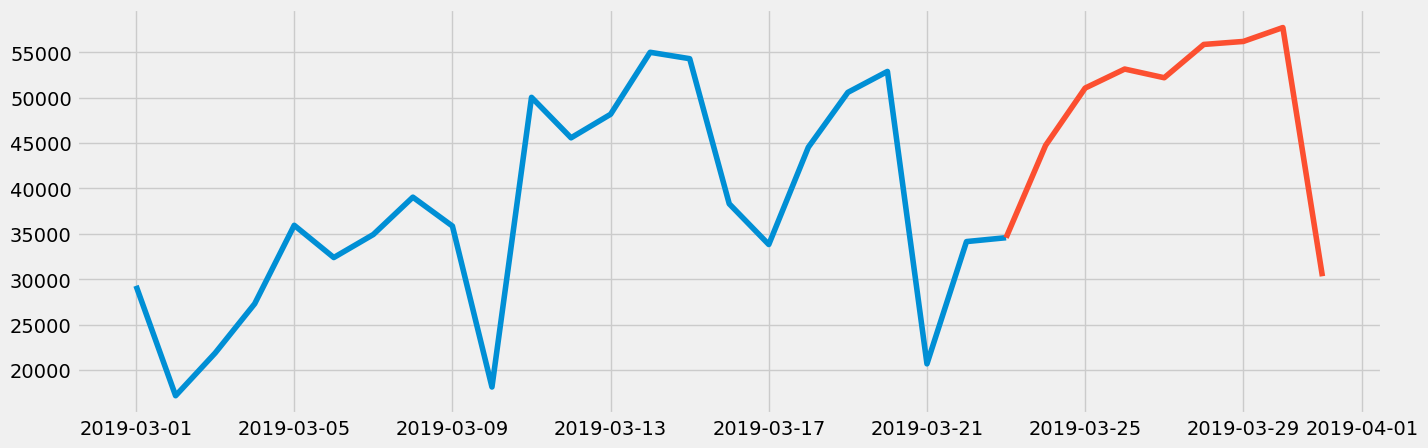

In [21]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

<a id='modeling'></a>
## Running and fitting the model

                               SARIMAX Results                                
Dep. Variable:           bikes_rented   No. Observations:                   31
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -330.768
Date:                Tue, 28 Nov 2023   AIC                            669.536
Time:                        14:19:28   BIC                            675.272
Sample:                    03-01-2019   HQIC                           671.405
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.05e+04   4183.924      9.680      0.000    3.23e+04    4.87e+04
ar.L1          0.5204      0.566      0.919      0.358      -0.589       1.630
ma.L1         -0.0162      0.762     -0.021      0.9

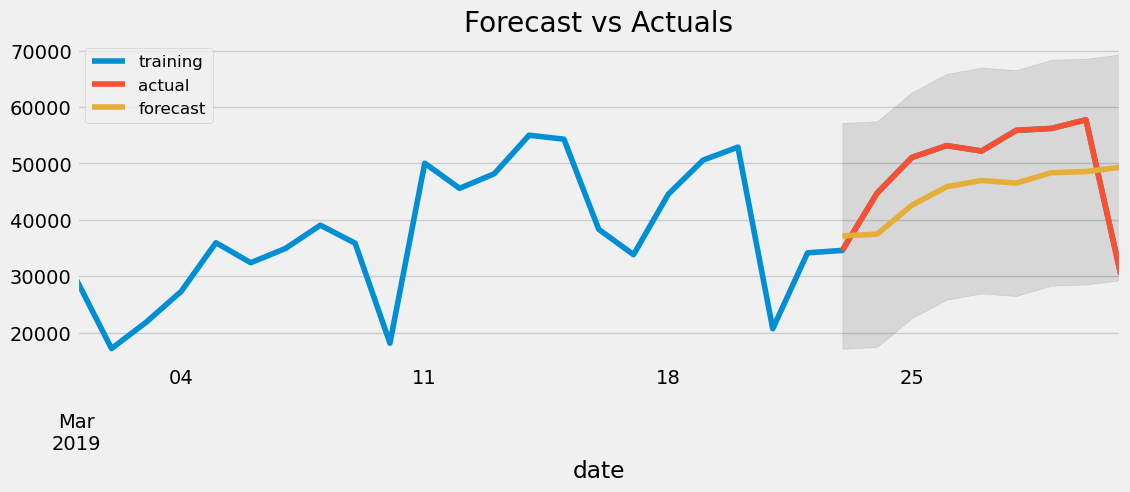

In [22]:
# First iteration of ARIMA model

model = ARIMA(df, order=(1, 0, 1)) # I had to model the entire data set instead of the train set.
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
pred = fitted.get_prediction(start=test.index[0], dynamic=False) # Using code from the resource to obtain the intervals
pred_ci = pred.conf_int()

# Plot
ax = df.plot()
plt.plot(test, label='actual')
pred.predicted_mean.plot(ax=ax, label='forecast', figsize=(12,4))
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.1)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12).get_texts()[0].set_text('training')
plt.show()

Not all the coefficients are significant. However, the forecast aligns fairly well to the actual values. Since we didn't get all the coefficients significant, I will run a second iteration with p = 1, d = 0, and q = 0.

                               SARIMAX Results                                
Dep. Variable:           bikes_rented   No. Observations:                   31
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -330.763
Date:                Tue, 28 Nov 2023   AIC                            667.525
Time:                        14:19:36   BIC                            671.827
Sample:                    03-01-2019   HQIC                           668.927
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.05e+04   3715.231     10.901      0.000    3.32e+04    4.78e+04
ar.L1          0.5080      0.138      3.678      0.000       0.237       0.779
sigma2      1.079e+08      0.213   5.06e+08      0.0

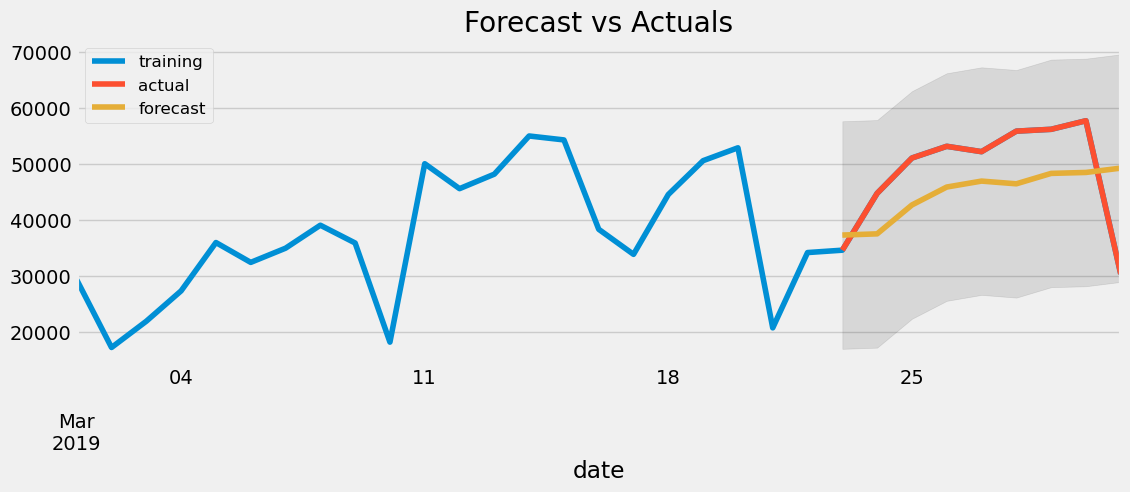

In [23]:
# Second iteration of ARIMA model

model = ARIMA(df, order=(1, 0, 0)) # I had to model the entire data set instead of the train set.
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
pred = fitted.get_prediction(start=test.index[0], dynamic=False) # Using code from the resource to obtain the intervals
pred_ci = pred.conf_int()

# Plot
ax = df.plot()
plt.plot(test, label='actual')
pred.predicted_mean.plot(ax=ax, label='forecast', figsize=(12,4))
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.1)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12).get_texts()[0].set_text('training')
plt.show()

All the coefficients are significant, and the forecasts align fairly well with the actual values.